In [699]:
from minisom import MiniSom
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import random
from Square import colors

data = pd.read_csv('SomXYZ.csv')
data = data.values
#moim zdaniem chyba nie potrzeba tutaj normalizować danych, ewentualnie po zmianach wartości x oraz y z jest zawsze -1 do 1
print(data.shape)

(10000, 3)


In [700]:
# colors = ["#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
#         "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
#         "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
#         "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
#         "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
#         "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
#         "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
#         "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
#         "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
#         "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
#         "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
#         "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
#         "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
#         "#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800",
#         "#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51",
#         "#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58",
#         "#7A7BFF", "#D68E01", "#353339", "#78AFA1", "#FEB2C6", "#75797C", "#837393", "#943A4D",
#         "#B5F4FF", "#D2DCD5", "#9556BD", "#6A714A", "#001325", "#02525F", "#0AA3F7", "#E98176",
#         "#DBD5DD", "#5EBCD1", "#3D4F44", "#7E6405", "#02684E", "#962B75", "#8D8546", "#9695C5",
#         "#E773CE", "#D86A78", "#3E89BE", "#CA834E", "#518A87", "#5B113C", "#55813B", "#E704C4",
#         "#00005F", "#A97399", "#4B8160", "#59738A", "#FF5DA7", "#F7C9BF", "#643127", "#513A01",
#         "#6B94AA", "#51A058", "#A45B02", "#1D1702", "#E20027", "#E7AB63", "#4C6001", "#9C6966",
#         "#64547B", "#97979E", "#006A66", "#391406", "#F4D749", "#0045D2", "#006C31", "#DDB6D0",
#         "#7C6571", "#9FB2A4", "#00D891", "#15A08A", "#BC65E9", "#FFFFFE", "#C6DC99", "#203B3C",
#         "#671190", "#6B3A64", "#F5E1FF", "#FFA0F2", "#CCAA35", "#374527", "#8BB400", "#797868",
#         "#C6005A", "#3B000A", "#C86240", "#29607C", "#402334", "#7D5A44", "#CCB87C", "#B88183",
#         "#AA5199", "#B5D6C3", "#A38469", "#9F94F0", "#A74571", "#B894A6", "#71BB8C", "#00B433",
#         "#789EC9", "#6D80BA", "#953F00", "#5EFF03", "#E4FFFC", "#1BE177", "#BCB1E5", "#76912F",
#         "#003109", "#0060CD", "#D20096", "#895563", "#29201D", "#5B3213", "#A76F42", "#89412E",
#         "#1A3A2A", "#494B5A", "#A88C85", "#F4ABAA", "#A3F3AB", "#00C6C8", "#EA8B66", "#958A9F",
#         "#BDC9D2", "#9FA064", "#BE4700", "#658188", "#83A485", "#453C23", "#47675D", "#3A3F00",
#         "#061203", "#DFFB71", "#868E7E", "#98D058", "#6C8F7D", "#D7BFC2", "#3C3E6E", "#D83D66",
#         "#2F5D9B", "#6C5E46", "#D25B88", "#5B656C", "#00B57F", "#545C46", "#866097", "#365D25",
#         "#252F99", "#00CCFF", "#674E60", "#FC009C", "#92896B", "#1E2324", "#DEC9B2", "#9D4948",
#         "#85ABB4", "#342142", "#D09685", "#A4ACAC", "#00FFFF", "#AE9C86", "#742A33", "#0E72C5",
#         "#AFD8EC", "#C064B9", "#91028C", "#FEEDBF", "#FFB789", "#9CB8E4", "#AFFFD1", "#2A364C",
#         "#4F4A43", "#647095", "#34BBFF", "#807781", "#920003", "#B3A5A7", "#018615", "#F1FFC8",
#         "#976F5C", "#FF3BC1", "#FF5F6B", "#077D84", "#F56D93", "#5771DA", "#4E1E2A", "#830055",
#         "#02D346", "#BE452D", "#00905E", "#BE0028", "#6E96E3", "#007699", "#FEC96D", "#9C6A7D",
#         "#3FA1B8", "#893DE3", "#79B4D6", "#7FD4D9", "#6751BB", "#B28D2D", "#E27A05", "#DD9CB8",
#         "#AABC7A", "#980034", "#561A02", "#8F7F00", "#635000", "#CD7DAE", "#8A5E2D", "#FFB3E1",
#         "#6B6466", "#C6D300", "#0100E2", "#88EC69", "#8FCCBE", "#21001C", "#511F4D", "#E3F6E3",
#         "#FF8EB1", "#6B4F29", "#A37F46", "#6A5950", "#1F2A1A", "#04784D", "#101835", "#E6E0D0",
#         "#FF74FE", "#00A45F", "#8F5DF8", "#4B0059", "#412F23", "#D8939E", "#DB9D72", "#604143",
#         "#B5BACE", "#989EB7", "#D2C4DB", "#A587AF", "#77D796", "#7F8C94", "#FF9B03", "#555196",
#         "#31DDAE", "#74B671", "#802647", "#2A373F", "#014A68", "#696628", "#4C7B6D", "#002C27",
#         "#7A4522", "#3B5859", "#E5D381", "#FFF3FF", "#679FA0", "#261300", "#2C5742", "#9131AF",
#         "#AF5D88", "#C7706A", "#61AB1F", "#8CF2D4", "#C5D9B8", "#9FFFFB", "#BF45CC", "#493941",
#         "#863B60", "#B90076", "#003177", "#C582D2", "#C1B394", "#602B70", "#887868", "#BABFB0",
#         "#030012", "#D1ACFE", "#7FDEFE", "#4B5C71", "#A3A097", "#E66D53", "#637B5D", "#92BEA5",
#         "#00F8B3", "#BEDDFF", "#3DB5A7", "#DD3248", "#B6E4DE", "#427745", "#598C5A", "#B94C59",
#         "#8181D5", "#94888B", "#FED6BD", "#536D31", "#6EFF92", "#E4E8FF", "#20E200", "#FFD0F2",
#         "#4C83A1", "#BD7322", "#915C4E", "#8C4787", "#025117", "#A2AA45", "#2D1B21", "#A9DDB0",
#         "#FF4F78", "#528500", "#009A2E", "#17FCE4", "#71555A", "#525D82", "#00195A", "#967874",
#         "#555558", "#0B212C", "#1E202B", "#EFBFC4", "#6F9755", "#6F7586", "#501D1D", "#372D00",
#         "#741D16", "#5EB393", "#B5B400", "#DD4A38", "#363DFF", "#AD6552", "#6635AF", "#836BBA",
#         "#98AA7F", "#464836", "#322C3E", "#7CB9BA", "#5B6965", "#707D3D", "#7A001D", "#6E4636",
#         "#443A38", "#AE81FF", "#489079", "#897334", "#009087", "#DA713C", "#361618", "#FF6F01",
#         "#006679", "#370E77", "#4B3A83", "#C9E2E6", "#C44170", "#FF4526", "#73BE54", "#C4DF72",
#         "#ADFF60", "#00447D", "#DCCEC9", "#BD9479", "#656E5B", "#EC5200", "#FF6EC2", "#7A617E",
#         "#DDAEA2", "#77837F", "#A53327", "#608EFF", "#B599D7", "#A50149", "#4E0025", "#C9B1A9",
#         "#03919A", "#1B2A25", "#E500F1", "#982E0B", "#B67180", "#E05859", "#006039", "#578F9B",
#         "#305230", "#CE934C", "#B3C2BE", "#C0BAC0", "#B506D3", "#170C10", "#4C534F", "#224451",
#         "#3E4141", "#78726D", "#B6602B", "#200441", "#DDB588", "#497200", "#C5AAB6", "#033C61",
#         "#71B2F5", "#A9E088", "#4979B0", "#A2C3DF", "#784149", "#2D2B17", "#3E0E2F", "#57344C",
#         "#0091BE", "#E451D1", "#4B4B6A", "#5C011A", "#7C8060", "#FF9491", "#4C325D", "#005C8B",
#         "#E5FDA4", "#68D1B6", "#032641", "#140023", "#8683A9", "#CFFF00", "#A72C3E", "#34475A",
#         "#B1BB9A", "#B4A04F", "#8D918E", "#A168A6", "#813D3A", "#425218", "#DA8386", "#776133",
#         "#563930", "#8498AE", "#90C1D3", "#B5666B", "#9B585E", "#856465", "#AD7C90", "#E2BC00",
#         "#E3AAE0", "#B2C2FE", "#FD0039", "#009B75", "#FFF46D", "#E87EAC", "#DFE3E6", "#848590",
#         "#AA9297", "#83A193", "#577977", "#3E7158", "#C64289", "#EA0072", "#C4A8CB", "#55C899",
#         "#E78FCF", "#004547", "#F6E2E3", "#966716", "#378FDB", "#435E6A", "#DA0004", "#1B000F",
#         "#5B9C8F", "#6E2B52", "#011115", "#E3E8C4", "#AE3B85", "#EA1CA9", "#FF9E6B", "#457D8B",
#         "#92678B", "#00CDBB", "#9CCC04", "#002E38", "#96C57F", "#CFF6B4", "#492818", "#766E52",
#         "#20370E", "#E3D19F", "#2E3C30", "#B2EACE", "#F3BDA4", "#A24E3D", "#976FD9", "#8C9FA8",
#         "#7C2B73", "#4E5F37", "#5D5462", "#90956F", "#6AA776", "#DBCBF6", "#DA71FF", "#987C95",
#         "#52323C", "#BB3C42", "#584D39", "#4FC15F", "#A2B9C1", "#79DB21", "#1D5958", "#BD744E",
#         "#160B00", "#20221A", "#6B8295", "#00E0E4", "#102401", "#1B782A", "#DAA9B5", "#B0415D",
#         "#859253", "#97A094", "#06E3C4", "#47688C", "#7C6755", "#075C00", "#7560D5", "#7D9F00",
#         "#C36D96", "#4D913E", "#5F4276", "#FCE4C8", "#303052", "#4F381B", "#E5A532", "#706690",
#         "#AA9A92", "#237363", "#73013E", "#FF9079", "#A79A74", "#029BDB", "#FF0169", "#C7D2E7",
#         "#CA8869", "#80FFCD", "#BB1F69", "#90B0AB", "#7D74A9", "#FCC7DB", "#99375B", "#00AB4D",
#         "#ABAED1", "#BE9D91", "#E6E5A7", "#332C22", "#DD587B", "#F5FFF7", "#5D3033", "#6D3800",
#         "#FF0020", "#B57BB3", "#D7FFE6", "#C535A9", "#260009", "#6A8781", "#A8ABB4", "#D45262",
#         "#794B61", "#4621B2", "#8DA4DB", "#C7C890", "#6FE9AD", "#A243A7", "#B2B081", "#181B00",
#         "#286154", "#4CA43B", "#6A9573", "#A8441D", "#5C727B", "#738671", "#D0CFCB", "#897B77",
#         "#1F3F22", "#4145A7", "#DA9894", "#A1757A", "#63243C", "#ADAAFF", "#00CDE2", "#DDBC62",
#         "#698EB1", "#208462", "#00B7E0", "#614A44", "#9BBB57", "#7A5C54", "#857A50", "#766B7E",
#         "#014833", "#FF8347", "#7A8EBA", "#274740", "#946444", "#EBD8E6", "#646241", "#373917",
#         "#6AD450", "#81817B", "#D499E3", "#979440", "#011A12", "#526554", "#B5885C", "#A499A5",
#         "#03AD89", "#B3008B", "#E3C4B5", "#96531F", "#867175", "#74569E", "#617D9F", "#E70452",
#         "#067EAF", "#A697B6", "#B787A8", "#9CFF93", "#311D19", "#3A9459", "#6E746E", "#B0C5AE",
#         "#84EDF7", "#ED3488", "#754C78", "#384644", "#C7847B", "#00B6C5", "#7FA670", "#C1AF9E",
#         "#2A7FFF", "#72A58C", "#FFC07F", "#9DEBDD", "#D97C8E", "#7E7C93", "#62E674", "#B5639E",
#         "#FFA861", "#C2A580", "#8D9C83", "#B70546", "#372B2E", "#0098FF", "#985975", "#20204C",
#         "#FF6C60", "#445083", "#8502AA", "#72361F", "#9676A3", "#484449", "#CED6C2", "#3B164A",
#         "#CCA763", "#2C7F77", "#02227B", "#A37E6F", "#CDE6DC", "#CDFFFB", "#BE811A", "#F77183",
#         "#EDE6E2", "#CDC6B4", "#FFE09E", "#3A7271", "#FF7B59", "#4E4E01", "#4AC684", "#8BC891",
#         "#BC8A96", "#CF6353", "#DCDE5C", "#5EAADD", "#F6A0AD", "#E269AA", "#A3DAE4", "#436E83",
#         "#002E17", "#ECFBFF", "#A1C2B6", "#50003F", "#71695B", "#67C4BB", "#536EFF", "#5D5A48",
#         "#890039", "#969381", "#371521", "#5E4665", "#AA62C3", "#8D6F81", "#2C6135", "#410601",
#         "#564620", "#E69034", "#6DA6BD", "#E58E56", "#E3A68B", "#48B176", "#D27D67", "#B5B268",
#         "#7F8427", "#FF84E6", "#435740", "#EAE408", "#F4F5FF", "#325800", "#4B6BA5", "#ADCEFF",
#         "#9B8ACC", "#885138", "#5875C1", "#7E7311", "#FEA5CA", "#9F8B5B", "#A55B54", "#89006A",
#         "#AF756F", "#2A2000", "#576E4A", "#7F9EFF", "#7499A1", "#FFB550", "#00011E", "#D1511C",
#         "#688151", "#BC908A", "#78C8EB", "#8502FF", "#483D30", "#C42221", "#5EA7FF", "#785715",
#         "#0CEA91", "#FFFAED", "#B3AF9D", "#3E3D52", "#5A9BC2", "#9C2F90", "#8D5700", "#ADD79C",
#         "#00768B", "#337D00", "#C59700", "#3156DC", "#944575", "#ECFFDC", "#D24CB2", "#97703C",
#         "#4C257F", "#9E0366", "#88FFEC", "#B56481", "#396D2B", "#56735F", "#988376", "#9BB195",
#         "#A9795C", "#E4C5D3", "#9F4F67", "#1E2B39", "#664327", "#AFCE78", "#322EDF", "#86B487",
#         "#C23000", "#ABE86B", "#96656D", "#250E35", "#A60019", "#0080CF", "#CAEFFF", "#323F61",
#         "#A449DC", "#6A9D3B", "#FF5AE4", "#636A01", "#D16CDA", "#736060", "#FFBAAD", "#D369B4",
#         "#FFDED6", "#6C6D74", "#927D5E", "#845D70", "#5B62C1", "#2F4A36", "#E45F35", "#FF3B53",
#         "#AC84DD", "#762988", "#70EC98", "#408543", "#2C3533", "#2E182D", "#323925", "#19181B",
#         "#2F2E2C", "#023C32", "#9B9EE2", "#58AFAD", "#5C424D", "#7AC5A6", "#685D75", "#B9BCBD",
#         "#834357", "#1A7B42", "#2E57AA", "#E55199", "#316E47", "#CD00C5", "#6A004D", "#7FBBEC",
#         "#F35691", "#D7C54A", "#62ACB7", "#CBA1BC", "#A28A9A", "#6C3F3B", "#FFE47D", "#DCBAE3",
#         "#5F816D", "#3A404A", "#7DBF32", "#E6ECDC", "#852C19", "#285366", "#B8CB9C", "#0E0D00",
#         "#4B5D56", "#6B543F", "#E27172", "#0568EC", "#2EB500", "#D21656", "#EFAFFF", "#682021",
#         "#2D2011", "#DA4CFF", "#70968E", "#FF7B7D", "#4A1930", "#E8C282", "#E7DBBC", "#A68486",
#         "#1F263C", "#36574E", "#52CE79", "#ADAAA9", "#8A9F45", "#6542D2", "#00FB8C", "#5D697B",
#         "#CCD27F", "#94A5A1", "#790229", "#E383E6", "#7EA4C1", "#4E4452", "#4B2C00", "#620B70",
#         "#314C1E", "#874AA6", "#E30091", "#66460A", "#EB9A8B", "#EAC3A3", "#98EAB3", "#AB9180",
#         "#B8552F", "#1A2B2F", "#94DDC5", "#9D8C76", "#9C8333", "#94A9C9", "#392935", "#8C675E",
#         "#CCE93A", "#917100", "#01400B", "#449896", "#1CA370", "#E08DA7", "#8B4A4E", "#667776",
#         "#4692AD", "#67BDA8", "#69255C", "#D3BFFF", "#4A5132", "#7E9285", "#77733C", "#E7A0CC",
#         "#51A288", "#2C656A", "#4D5C5E", "#C9403A", "#DDD7F3", "#005844", "#B4A200", "#488F69",
#         "#858182", "#D4E9B9", "#3D7397", "#CAE8CE", "#D60034", "#AA6746", "#9E5585", "#BA6200"]

In [701]:
print(data[:,2][3])

0.2588190451025207


In [702]:
class Square:
  def __init__(self, points, x_position, y_position, bad_square = False):
    self.points = points
    self.points_to_train = np.concatenate(self.points)
    self.x_position = x_position
    self.y_position = y_position
    self.bad_square = bad_square
    self.colored_points = []
  def get_position(self):
    return [self.x_position, self.y_position]
  
  def randomize_points(self, randomization_percent):
    self.bad_square = True
    points_count = len(self.points)
    points_to_randomize = int((points_count * randomization_percent) / 100)
    random_indices = np.random.choice(range(points_count), points_to_randomize)
    for index in random_indices:
        self.points[index][2] += random.uniform(-1,1) #zmienia Z
    self.points_to_train = np.concatenate(self.points)

  def color_my_points(self, color):
    rgb = self.hex_to_rgb(color)
    for i in range(self.points.shape[0]):
      self.colored_points.append(np.concatenate((self.points[i], rgb)))
    return self.colored_points

    
  def hex_to_rgb(self, hex_code):
    hex_code = hex_code.lstrip('#')  # Remove leading '#' if present
    return np.array(tuple(int(hex_code[i:i+2], 16) for i in (0, 2, 4)))

  def svd_method(self):
    centroid = np.mean(self.points, axis=0)
    centered_points = self.points - centroid
    U, S, Vh = np.linalg.svd(centered_points)
    normal_vector = Vh[:, -1] #do sprawdzenia
    self.normal_vector = normal_vector
    return normal_vector
  
  def moments_method(self):
    centroid = np.mean(self.points, axis=0)
    centered_points = self.points - centroid
    Mx = np.mean(self.points[:,0])
    My = np.mean(self.points[:,1])
    Mz = np.mean(self.points[:,2])

    Mxx = np.mean((self.points[:,0] - Mx) ** 2)
    Myy = np.mean((self.points[:,1] - My) ** 2)
    Mzz = np.mean((self.points[:,2] - Mz) ** 2)
    Mxy = np.mean((self.points[:,0] - Mx)  * (self.points[:,1] - My))
    Mxz = np.mean((self.points[:,0] - Mx)  * (self.points[:,2] - Mz))
    Myz = np.mean((self.points[:,1] - My)  * (self.points[:,2] - Mz))

    a = Mxx / (Mxx + Myy + Mzz)
    b = Myy / (Mxx + Myy + Mzz)
    c = Mzz / (Mxx + Myy + Mzz)
    d = - (a*Mx + b*My + c*Mz)

    self.normal_vector = np.array([a,b,c])
    return np.array([a,b,c])



    
  

In [703]:
x_values = data[:,0]
y_values = data[:,1]
z_values = data[:,2]
min_x = min(x_values)
min_y = min(y_values)
max_x = max(x_values)
max_y = max(y_values)

In [704]:
#nasz group_array nie ma sensu gdyz dzieli on listę np od recordu 0 do 50, a my poruszamy się w 3d więc musi dzielić np x: 0-5, y: 0-5
#mam na to napisaną metodę w c#
def group_array(data, x_jump, y_jump):
    x_segments_count = int((max(x_values) - min(x_values)) / x_jump)
    y_segments_count = int((max(y_values) - min(y_values)) / y_jump)
    segmented_points = []

    x = min_x
    y = min_y

    x_iterator = x_segments_count
    while(x_iterator >= 0):
       y_iterator = y_segments_count
       while(y_iterator >= 0):
          points = [point for point in data if point[0] >= x and point[0] < x + x_jump and point[1] >= y and point[1] < y+y_jump]
          x_pos = x_segments_count - x_iterator
          y_pos = y_segments_count - y_iterator
          segmented_points.append(Square(np.array(points), x_pos, y_pos))

          y += y_jump
          y_iterator = y_iterator -1
       x += x_jump
       y = min_y
       x_iterator = x_iterator - 1
    return(np.array(segmented_points))
    
squares = group_array(data,10,10)


In [705]:
squares[0].randomize_points(70) 
bad_square = squares[0]

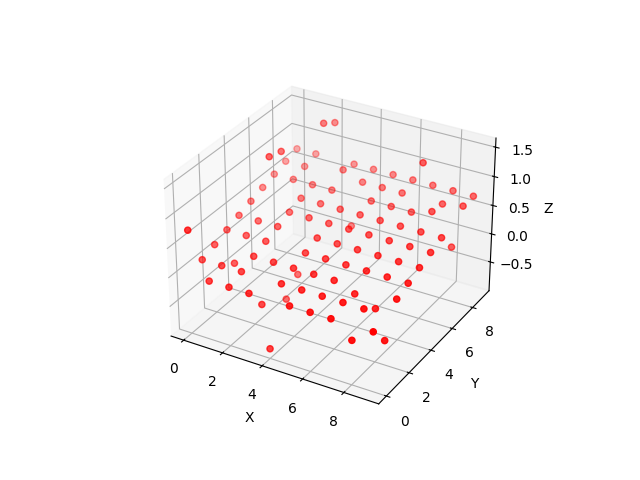

In [706]:
%matplotlib ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') 

# Wykres punktowy 3D
ax.scatter(bad_square.points[:,0], bad_square.points[:,1], bad_square.points[:,2], c='r', marker='o')  # c - kolor,  marker - kształt punktoru

# Ustawianie etykiet osi
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Wyświetlenie wykresu
plt.show()

In [707]:
som_3dim = squares[0].points_to_train.shape[0] #ilość wag w neuronie
points_to_train = np.array([x.points_to_train for x in squares]) #tworzenie listy składającej się z wektorów gotowych do treningu 


In [708]:
som_x, som_y = 10,10
som = MiniSom(som_x, som_y, som_3dim, random_seed=42)
som.train(points_to_train, 10000)

In [709]:
print(som.winner(bad_square.points_to_train))
print(bad_square.get_position())

(0, 0)
[0, 0]


In [710]:
#tworzenie mapy kolorów
som_colors = np.empty((som_x, som_y), dtype='object')
color_idx = 0
for i in range(som_x):
    for j in range (som_y):
        som_colors[i,j] = colors[color_idx]
        color_idx+= 1
print(som_colors[1][0])

#0000A6


In [711]:
#kolorowanie punktów sinusoidy
winner_pos = som.winner(bad_square.points_to_train)
col = som_colors[winner_pos[0], winner_pos[1]]
print(col)
bad_square.color_my_points(col)
for square in squares:
    winner_pos = som.winner(bad_square.points_to_train)
    col = som_colors[winner_pos[0], winner_pos[1]]
    square.color_my_points(col)


#000000


In [712]:
svd_normal_vector = bad_square.svd_method()
moments = bad_square.moments_method()
print(svd_normal_vector)
print(moments)

[-9.97545870e-02 -6.10622664e-16  9.95012071e-01]
[0.49573004 0.49573004 0.00853992]


In [713]:
print( squares[41].points[:,1])

[10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 10. 11. 12. 13. 14. 15.
 16. 17. 18. 19. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 10. 11. 12. 13.
 14. 15. 16. 17. 18. 19. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 10. 11.
 12. 13. 14. 15. 16. 17. 18. 19. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.]


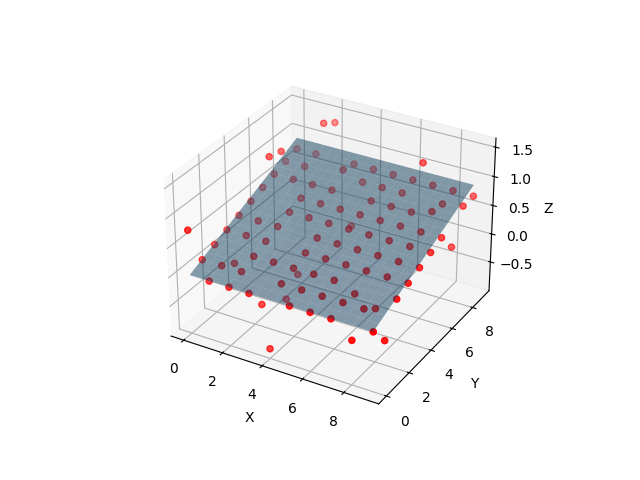

In [714]:
normal_x, normal_y, normal_Z = svd_normal_vector
# Create grid values
x = np.linspace(min(bad_square.points[:,1]), max(bad_square.points[:,1]),20) #x i y są zamienione miejscami ???
y = np.linspace(min(bad_square.points[:,0]), max(bad_square.points[:,0]),20)
xx, yy = np.meshgrid(x, y)

# Calculate Z values
Z = (-normal_x * xx - normal_y * yy) / normal_Z

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(bad_square.points[:,0], bad_square.points[:,1], bad_square.points[:,2], c='r', marker='o')  # c - kolor,  marker - kształt punktoru

ax.plot_surface(yy, xx, Z, alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [715]:
import csv
def print_out_squares(squares): #zmien nazwe
    formatted_numbers = []
    with open('numbers.csv', 'w', newline='') as csvfile:
        for suqare in squares:
            points_to_print = suqare.colored_points
            writer = csv.writer(csvfile)
            for point in points_to_print:
                for num in point:
                    formatted_numbers.append("{}".format(num))
                writer.writerow(formatted_numbers)
                formatted_numbers = []
print_out_squares(squares)

In [716]:
#przyjrzeć się metodzie som.labels_map()
#https://github.com/JustGlowing/minisom/blob/master/examples/Classification.ipynb
#przemyśleć czy całego generowania kwadratu nie przenieść do pliku od generowania daty
#nowa zaproponowana formuła danych: Dane: w jednej linii jeden kwadrat, Label, dla jednego kwadratu czy jest popsuty czy nie